# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"


## Load Data

In [2]:
import os
os.getcwd()


'/scratch/hpda/indycar/predictor/notebook'

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'

inputfile = 'C_indycar-' + year +'.csv'
outputprefix = year +'-'

In [4]:
final_lap = 200

total_laps = final_lap + 1

dataset = pd.read_csv(inputfile)

# get records for the cars that finish the race
completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values

completed_car_count = len(completed_car_numbers)

print('count of completed cars:', completed_car_count)
print('completed cars:', completed_car_numbers)

#make a copy
alldata = dataset.copy()
dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]

count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]


In [5]:
dataset.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True).head(40)

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
3,4,1,3,0,0.4150,89.7686,T,0.0000,0,0.4150,...,0.1903,0,4,0.0000,Active,G,0,0,4,0
39,4,1,3,1,42.7829,42.3679,T,42.3679,1,0.8457,...,0.5677,0,4,42.3679,Active,G,0,0,4,0
118,4,1,3,1,42.7829,42.3679,T,42.3679,1,0.0000,...,0.5677,0,4,42.3679,Active,G,0,0,4,0
150,4,1,3,2,83.8813,41.0984,T,41.0984,2,1.1695,...,0.6452,0,4,41.0984,Active,G,0,0,4,0
201,4,1,3,2,83.8813,41.0984,T,41.0984,2,0.0000,...,0.6968,0,4,41.0984,Active,G,0,0,4,0
232,4,1,3,2,83.8813,41.0984,T,41.0984,2,0.0000,...,0.0000,1,4,41.0984,Active,G,0,0,4,0
233,4,1,3,3,124.9756,41.0943,T,41.0943,3,1.4571,...,0.4572,0,4,41.0943,Active,G,0,0,4,0
281,4,1,3,3,124.9756,41.0943,T,41.0943,3,0.0000,...,0.4572,0,4,41.0943,Active,G,0,0,4,0
312,4,1,3,3,124.9756,41.0943,T,41.0943,3,0.0000,...,0.0000,1,4,41.0943,Active,G,0,0,4,0
313,4,1,3,4,166.0936,41.1180,T,41.0943,3,1.7348,...,0.4834,0,4,41.0943,Active,G,0,0,4,0


In [6]:
dataset.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10216 entries, 0 to 18498
Data columns (total 21 columns):
rank                    10216 non-null int64
car_number              10216 non-null int64
unique_id               10216 non-null object
completed_laps          10216 non-null int64
elapsed_time            10216 non-null float64
last_laptime            10216 non-null float64
lap_status              10216 non-null object
best_laptime            10216 non-null float64
best_lap                10216 non-null object
time_behind_leader      10216 non-null float64
laps_behind_leade       10216 non-null object
time_behind_prec        10216 non-null float64
laps_behind_prec        10216 non-null object
overall_rank            10216 non-null object
overall_best_laptime    10216 non-null float64
current_status          10216 non-null object
track_status            10216 non-null object
pit_stop_count          10216 non-null object
last_pitted_lap         10216 non-null object
start_position

## Prepare data for RNN

In [7]:
#univariate dataset
uni_ds = dataset.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
uni_ds=uni_ds.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)
uni_ds=uni_ds.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

# convert time to minutes
uni_ds.head(10)

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,time_behind_leader,time_behind_prec,overall_best_laptime
3,4,1,0,0.4150,89.7686,0.0000,0.4150,0.1903,0.0000
39,4,1,1,42.7829,42.3679,42.3679,0.8457,0.5677,42.3679
150,4,1,2,83.8813,41.0984,41.0984,1.1695,0.6452,41.0984
233,4,1,3,124.9756,41.0943,41.0943,1.4571,0.4572,41.0943
313,4,1,4,166.0936,41.1180,41.0943,1.7348,0.4834,41.0943
395,4,1,5,207.1653,41.0717,41.0717,1.9046,0.7648,41.0717
476,4,1,6,248.3523,41.1870,41.0717,2.2024,0.8365,41.0717
560,4,1,7,289.6172,41.2649,41.0717,2.5373,0.8016,41.0717
645,4,1,8,330.9584,41.3412,41.0717,2.9428,0.9574,41.0717
731,4,1,9,372.3228,41.3644,41.0717,3.1394,1.2365,41.0717


In [8]:
carnumber = uni_ds.drop_duplicates(subset=['car_number'], keep='first')
carnumber

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,time_behind_leader,time_behind_prec,overall_best_laptime
3,4,1,0,0.4150,89.7686,0.0,0.4150,0.1903,0.0
10,11,4,0,1.4313,83.9523,0.0,1.4313,0.1748,0.0
18,18,6,0,3.0860,78.4949,0.0,3.0860,0.0166,0.0
6,9,9,0,0.9168,85.0895,0.0,0.9168,0.9168,0.0
2,3,12,0,0.2247,90.2903,0.0,0.2247,0.1127,0.0
29,30,15,0,4.3010,66.6294,0.0,4.3010,0.0000,0.0
0,1,20,0,0.0000,91.4880,0.0,0.0000,0.0000,0.0
1,2,22,0,0.1120,91.0722,0.0,0.1120,0.1120,0.0
15,15,23,0,2.4256,80.9017,0.0,2.4256,0.4635,0.0
23,23,25,0,3.7460,74.0287,0.0,3.7460,0.0000,0.0


In [9]:
uni_ds.describe()

,rank,car_number,completed_laps,elapsed_time,last_laptime,best_laptime,time_behind_leader,time_behind_prec,overall_best_laptime
count,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000,3618.000000
mean,12.646766,33.166667,100.000000,5234.542102,54.099012,40.635145,14.981057,1.466870,40.635145
std,7.459161,28.380850,58.031004,3192.651101,22.341758,2.919676,12.148815,3.080891,2.919676
min,1.000000,1.000000,0.000000,0.000000,40.195600,0.000000,0.000000,0.000000,0.000000
25%,6.000000,12.000000,50.000000,2268.115650,41.524100,40.524600,4.910700,0.425600,40.524600
50%,13.000000,24.000000,100.000000,5256.531450,42.121700,40.720200,12.896300,0.760950,40.720200
75%,18.000000,60.000000,150.000000,7951.618675,56.230500,41.018300,22.823825,1.445275,41.018300
max,32.000000,98.000000,200.000000,10824.151100,187.349300,45.716400,118.054100,93.711600,45.716400


In [10]:
uni_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3618 entries, 3 to 18474
Data columns (total 9 columns):
rank                    3618 non-null int64
car_number              3618 non-null int64
completed_laps          3618 non-null int64
elapsed_time            3618 non-null float64
last_laptime            3618 non-null float64
best_laptime            3618 non-null float64
time_behind_leader      3618 non-null float64
time_behind_prec        3618 non-null float64
overall_best_laptime    3618 non-null float64
dtypes: float64(6), int64(3)
memory usage: 282.7 KB


count    3618.000000
mean       53.706917
std        22.586723
min         0.000000
25%        41.517875
50%        42.108900
75%        55.704025
max       187.349300
Name: elapsed_time, dtype: float64


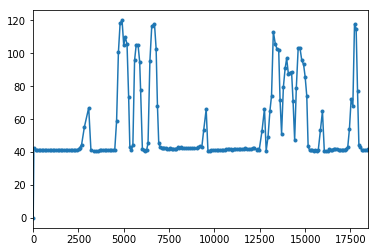

In [11]:

time_diff = uni_ds.diff(axis = 0, periods = 1)['elapsed_time']
time_diff[time_diff < 0] = 0

time_diff = time_diff.fillna(0)

print(time_diff.describe())

time_diff[:201].plot(marker='.')

In [12]:
time_diff[:10]

3       0.0000
39     42.3679
150    41.0984
233    41.0943
313    41.1180
395    41.0717
476    41.1870
560    41.2649
645    41.3412
731    41.3644
Name: elapsed_time, dtype: float64

In [13]:
#time_diff[uni_ds['car_number'] == 12].plot(marker='.')

In [14]:
#uni_ds[uni_ds['car_number'] == 12]['rank'].plot(marker='.') 

In [15]:
# check the car with crash
#car13 = alldata[alldata['car_number']==13]
#car13

In [16]:
# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):
    uni_ds = dataset.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
    uni_ds=uni_ds.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)
    uni_ds=uni_ds.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    carnumber = set(uni_ds['car_number'])
       
    
    # time diff
    time_diff = uni_ds.diff(axis = 0, periods = 1)['elapsed_time']
    time_diff[time_diff < 0] = 0
    time_diff = time_diff.fillna(0)

    print('cars:', carnumber)
    # car by car
    rank_diff = []
    for car in carnumber:
        thiscar = uni_ds[uni_ds['car_number']==car]
        diff = thiscar.diff(axis = 0, periods = 1)['rank']
        diff = diff.fillna(0)
        rank_diff.extend(diff)
        
    
    df = pd.DataFrame({'car_number':uni_ds['car_number'], 'lap_number':uni_ds['completed_laps'], 
                       'rank':uni_ds['rank'], 'elapsed_time':uni_ds['elapsed_time'],
                       'rank_diff':rank_diff, 'time_diff':time_diff})
    
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    
    return df


In [17]:
cldata = make_cl_data(dataset)
cldata.to_csv(outputprefix + 'completed_laps_diff.csv')

cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
cldata = make_cl_data(alldata)
cldata.to_csv(outputprefix + 'all_completed_laps_diff.csv')

cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}


/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/scratch/hpda/anaconda3/envs/predictor/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
outputprefix

'2018-'